In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import talib
from sklearn.model_selection import train_test_split

In [2]:
data=yf.download('^HSI','2019-01-01','2022-01-01')
# data.drop('Volume',1,inplace=True)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,25824.439453,25824.439453,25055.269531,25130.349609,25130.349609,1666316400
2019-01-03,25077.679688,25262.210938,24896.869141,25064.359375,25064.359375,1481291700
2019-01-04,24946.119141,25626.029297,24924.730469,25626.029297,25626.029297,1708572100
2019-01-07,26015.839844,26043.640625,25753.460938,25835.699219,25835.699219,1447090300
2019-01-08,25852.500000,25960.890625,25688.500000,25875.449219,25875.449219,1578205700
...,...,...,...,...,...,...
2021-12-24,23375.990234,23383.189453,23186.570312,23223.759766,23223.759766,622879700
2021-12-28,23282.349609,23319.439453,23099.480469,23280.560547,23280.560547,1433026700
2021-12-29,23253.980469,23253.980469,23008.279297,23086.539062,23086.539062,828414400


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
target=data['Prediction']

In [4]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
#k_features=10 (It will get top 10 features best suited for prediction)
#forward=False (Backward feature selection model)
#verbose=2 (It will show details output as shown below.)
#cv=5 (Kfold cross valiation: it will split the training set in 5 set and 4 will be using for training the model and 1 will using as validation)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
backwardModel=sfs(RandomForestRegressor(),k_features=10,forward=False,verbose=2,cv=5,n_jobs=-1,scoring='r2')
#We will convert our training data into numpy array. If we will not convert it, model is not able to read some of the column names.
backwardModel.fit(np.array(data.drop('Prediction',1)),target.values)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_48557/2118434002.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  backwardModel.fit(np.array(data.drop('Prediction',1)),target.values)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    4.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    5.8s finished

[2022-04-13 19:23:24] Features: 18/10 -- score: 0.9000178897742728[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    3.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    4.5s finished

[2022-04-13 19:23:29] Features: 17/10 -- score: 0.9015922354828716[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | ela

SequentialFeatureSelector(estimator=RandomForestRegressor(), forward=False,
                          k_features=10, n_jobs=-1, scoring='r2', verbose=2)

In [5]:
# data.drop(['OSC12','OSC6','MI12','MI6','%R10','%R5','RSI','TR'],1,inplace=True)
data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=target
data_val=data[-100:]
data=data[:-100]
sc = MinMaxScaler(feature_range = (-1, 1))
# X=sc.fit_transform(data.drop('Prediction',1))
X=data.drop('Prediction',1).values
# Y = data["Prediction"].values.reshape(-1,1)
# Y = sc_y.fit_transform(data["Prediction"].values.reshape(-1,1))
Y=np.array(data["Prediction"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(485, 10) (485,) (122, 10) (122,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_48557/1151953013.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Prediction']=target
/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_48557/1151953013.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=data.drop('Prediction',1).values


In [6]:
clf = RandomForestRegressor()

In [7]:
model = clf.fit(X_train, y_train)

In [8]:
y_pred=model.predict(X_test)

In [9]:
y_pred

array([29063.64552734, 29057.53701172, 29531.75537109, 29800.01244141,
       29871.11587891, 29791.10589844, 29786.99943359, 29849.3975    ,
       29808.6615625 , 29734.821875  , 29758.26242187, 29695.9384375 ,
       29761.31402344, 28893.48503906, 29422.20341797, 29084.82808594,
       29630.1634375 , 29132.40386719, 29161.57337891, 28455.67671875,
       28605.03164062, 28997.56400391, 29357.57681641, 28630.38994141,
       29083.34367188, 29009.49484375, 28996.30708984, 29523.36173828,
       29059.04339844, 28799.51796875, 28488.84103516, 28049.88953125,
       27678.0496875 , 28128.18025391, 28217.25664063, 28635.59470703,
       28412.2784375 , 29112.22896484, 28577.71375   , 29103.75095703,
       28587.25732422, 28441.37871094, 28447.97136719, 29021.22384766,
       28730.50076172, 29037.28117188, 29111.26679687, 29173.82046875,
       28610.30462891, 28592.28060547, 29168.50865234, 29102.26455078,
       29129.82927734, 29156.10767578, 29110.52777344, 28507.77841797,
      

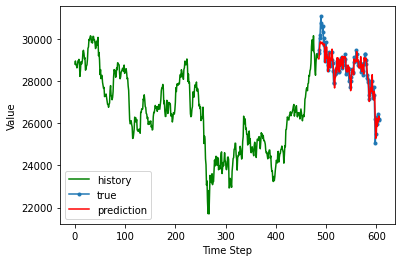

In [10]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [11]:
mean_absolute_percentage_error(y_test,y_pred)

0.011652273962293772

In [12]:
mean_squared_error(y_test,y_pred)

175202.99283720792

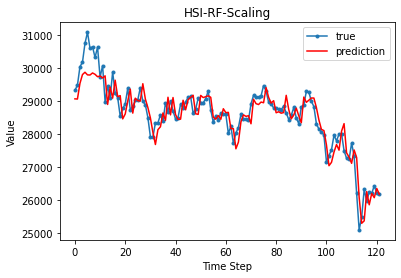

In [13]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-RF-Scaling')
plt.legend()
plt.show()

In [14]:
mean_absolute_percentage_error(y_test,y_pred)

0.011652273962293772

In [15]:
mean_squared_error(y_test,y_pred,squared=False)

418.5725657961925

In [16]:
r2_score(y_test,y_pred)

0.8393163447624872

In [17]:
x_val=data_val.drop('Prediction',1)
y_val=data_val['Prediction']
# x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
# x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=clf.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_48557/2115332834.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1)
/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


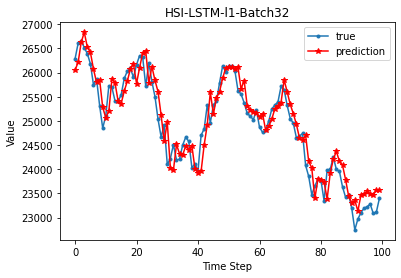

In [18]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSI-LSTM-l1-Batch32')
plt.legend()
plt.show()

In [19]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.010741628054234795

In [20]:
mean_squared_error(y_val,y_val_pred,squared=False)

325.5770947376474

In [21]:
r2_score(y_val,y_val_pred)

0.8949568546773791